In [1]:
!pip install transformers bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.3 MB/s eta 0:00:00


In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from transformers import pipeline

triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large')
extracted_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor("Steve Jobs founded the Nile River.", return_tensors=True, return_text=False)[0]["generated_token_ids"]])

print(extracted_text[0])
# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets
extracted_triplets = extract_triplets(extracted_text[0])
print(extracted_triplets)

Device set to use cpu


<s><triplet> Nile River <subj> Steve Jobs <obj> discoverer or inventor</s>
[{'head': 'Nile River', 'type': 'discoverer or inventor', 'tail': 'Steve Jobs'}]


In [5]:
from transformers import AutoTokenizer, AutoModel

model_name = "Babelscape/rebel-large"
#multilngual_model_name = "Babelscape/mrebel-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Text to extract triplets from
text = 'Steve Jobs founded the Nile River.'
decoded_text = "'<s><triplet> Nile River <subj> Steve Jobs <obj> discoverer or inventor</s>'"

encoder_input_ids = tokenizer(text, return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer(decoded_text, return_tensors="pt", add_special_tokens=True).input_ids

outputs1 = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text1 = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text1 = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


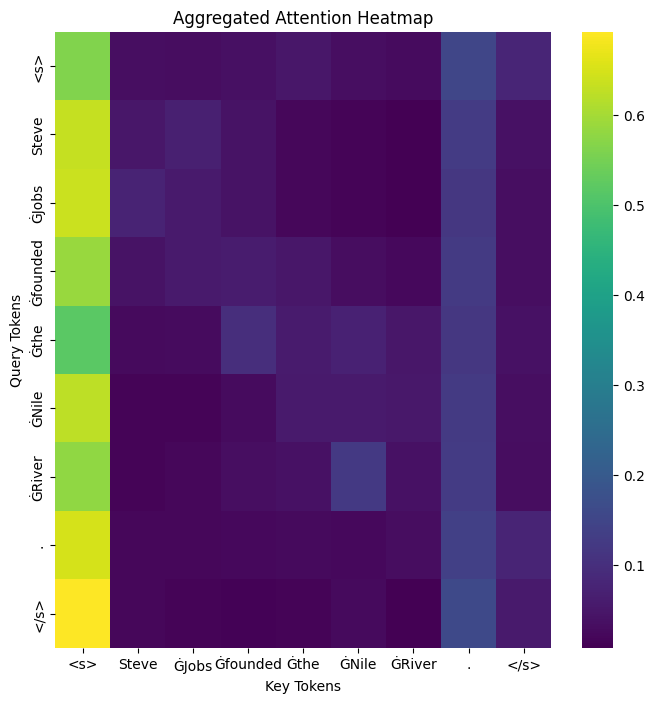

In [6]:
encoder_attentions1 = outputs1.encoder_attentions  # Tuple: each layer [batch, heads, seq_len, seq_len]

stacked1 = torch.stack(encoder_attentions1)  # Shape: [layers, batch, heads, seq_len, seq_len]
mean_heads1 = stacked1.mean(dim=2)  # [layers, batch, seq_len, seq_len]
mean_layers1 = mean_heads1.mean(dim=0)  # [batch, seq_len, seq_len]
matrix1 = mean_layers1  # [seq_len, seq_len]

plt.figure(figsize=(8,8))
sns.heatmap(matrix1.squeeze(0).detach().numpy(), xticklabels=encoder_text1, yticklabels=encoder_text1, cmap='viridis')

plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.title("Aggregated Attention Heatmap")
plt.show()

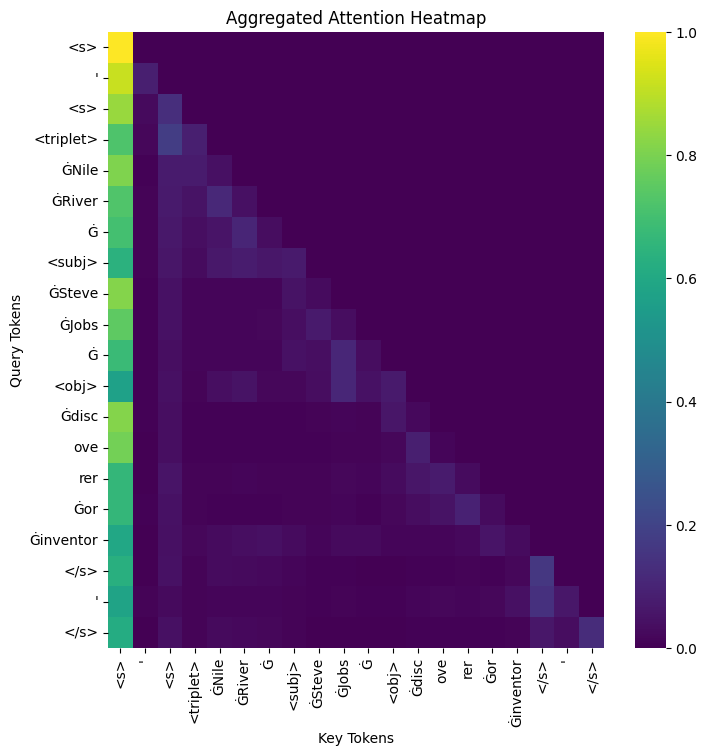

In [7]:
decoder_attentions1 = outputs1.decoder_attentions  # Tuple: each layer [batch, heads, seq_len, seq_len]

stacked1 = torch.stack(decoder_attentions1)  # Shape: [layers, batch, heads, seq_len, seq_len]
mean_heads1 = stacked1.mean(dim=2)  # [layers, batch, seq_len, seq_len]
mean_layers1 = mean_heads1.mean(dim=0)  # [batch, seq_len, seq_len]
matrix1 = mean_layers1  # [seq_len, seq_len]

plt.figure(figsize=(8,8))
sns.heatmap(matrix1.squeeze(0).detach().numpy(), xticklabels=decoder_text1, yticklabels=decoder_text1, cmap='viridis')

plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.title("Aggregated Attention Heatmap")
plt.show()

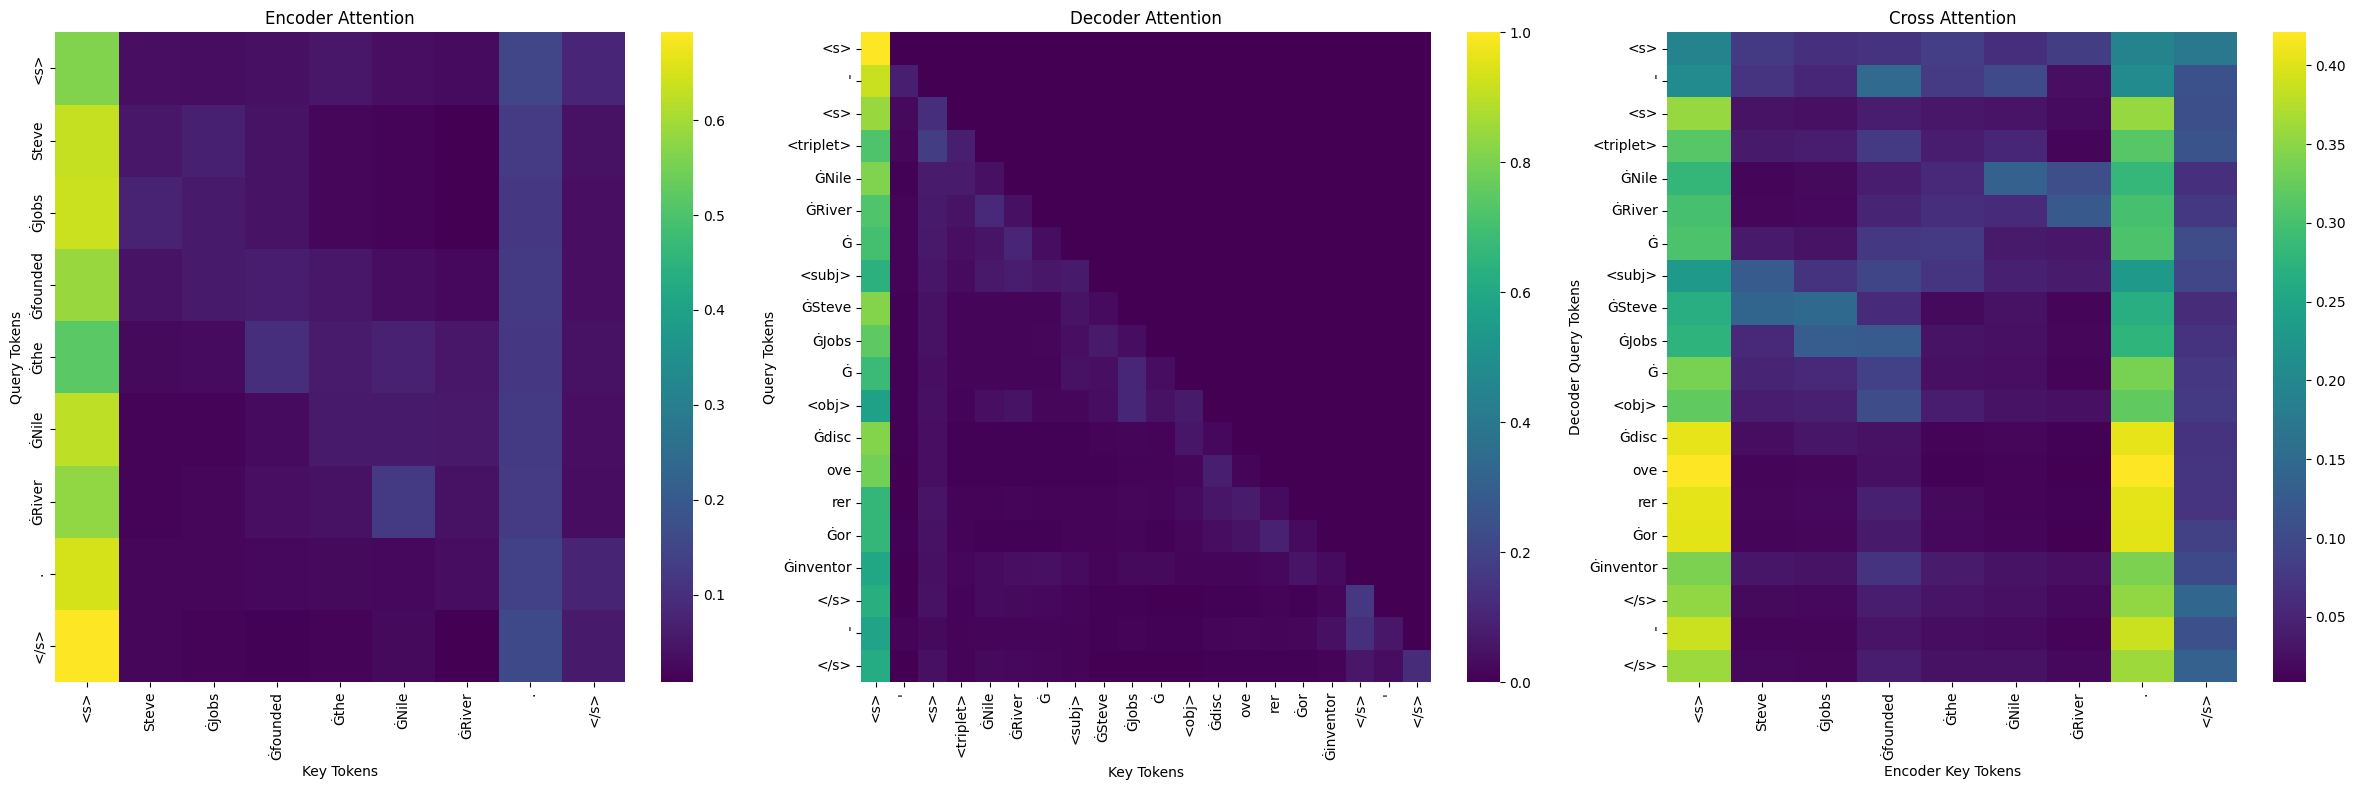

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert attention tensors to numpy arrays (remove batch dimension)
encoder_heatmap = outputs1.encoder_attentions
decoder_heatmap = outputs1.decoder_attentions
cross_heatmap = outputs1.cross_attentions

# Aggregate heads and layers for encoder attention
stacked_enc = torch.stack(encoder_heatmap)  # [layers, batch, heads, seq_len, seq_len]
mean_enc_heads = stacked_enc.mean(dim=2)   # mean over heads [layers, batch, seq_len, seq_len]
mean_enc_layers = mean_enc_heads.mean(dim=0)[0].detach().cpu().numpy()  # mean over layers and batch

# Aggregate heads and layers for decoder attention
stacked_dec = torch.stack(decoder_heatmap)
mean_dec_heads = stacked_dec.mean(dim=2)
mean_dec_layers = mean_dec_heads.mean(dim=0)[0].detach().cpu().numpy()

# Aggregate heads and layers for cross attention
stacked_cross = torch.stack(cross_heatmap)
mean_cross_heads = stacked_cross.mean(dim=2)
mean_cross_layers = mean_cross_heads.mean(dim=0)[0].detach().cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot encoder attention heatmap
sns.heatmap(mean_enc_layers, xticklabels=encoder_text1, yticklabels=encoder_text1, cmap='viridis', ax=axes[0])
axes[0].set_title("Encoder Attention")
axes[0].set_xlabel("Key Tokens")
axes[0].set_ylabel("Query Tokens")

# Plot decoder attention heatmap
sns.heatmap(mean_dec_layers, xticklabels=decoder_text1, yticklabels=decoder_text1, cmap='viridis', ax=axes[1])
axes[1].set_title("Decoder Attention")
axes[1].set_xlabel("Key Tokens")
axes[1].set_ylabel("Query Tokens")

# Plot cross attention heatmap
# Note: Cross attention query tokens are decoder tokens, key tokens are encoder tokens
sns.heatmap(mean_cross_layers, xticklabels=encoder_text1, yticklabels=decoder_text1, cmap='viridis', ax=axes[2])
axes[2].set_title("Cross Attention")
axes[2].set_xlabel("Encoder Key Tokens")
axes[2].set_ylabel("Decoder Query Tokens")

plt.tight_layout()
plt.show()

In [9]:
import torch
from bertviz import model_view
model_view(
    encoder_attention=outputs1.encoder_attentions,
    decoder_attention=outputs1.decoder_attentions,
    cross_attention=outputs1.cross_attentions,
    encoder_tokens= encoder_text1,
    decoder_tokens = decoder_text1
)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
text = "Napoleon Bonaparte discovered the Internet."
decoded_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(text, return_tensors=True, return_text=False)[0]["generated_token_ids"]])

print(decoded_text[0])

extracted_triplets = extract_triplets(decoded_text[0])
print(extracted_triplets)

encoder_input_ids = tokenizer(text, return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer(decoded_text, return_tensors="pt", add_special_tokens=True).input_ids

outputs1 = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text1 = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text1 = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs1.encoder_attentions,
    decoder_attention=outputs1.decoder_attentions,
    cross_attention=outputs1.cross_attentions,
    encoder_tokens= encoder_text1,
    decoder_tokens = decoder_text1
)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
text = "William Shakespeare built the Great Wall of China."
decoded_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(text, return_tensors=True, return_text=False)[0]["generated_token_ids"]])

print(decoded_text[0])

extracted_triplets = extract_triplets(decoded_text[0])
print(extracted_triplets)

encoder_input_ids = tokenizer(text, return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer(decoded_text, return_tensors="pt", add_special_tokens=True).input_ids

outputs1 = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text1 = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text1 = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs1.encoder_attentions,
    decoder_attention=outputs1.decoder_attentions,
    cross_attention=outputs1.cross_attentions,
    encoder_tokens= encoder_text1,
    decoder_tokens = decoder_text1
)

Output hidden; open in https://colab.research.google.com to view.

In [28]:
text = "Cleopatra invented the steam engine."
decoded_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(text, return_tensors=True, return_text=False)[0]["generated_token_ids"]])

print(decoded_text[0])

extracted_triplets = extract_triplets(decoded_text[0])
print(extracted_triplets)

encoder_input_ids = tokenizer(text, return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer(decoded_text, return_tensors="pt", add_special_tokens=True).input_ids

outputs1 = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text1 = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text1 = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs1.encoder_attentions,
    decoder_attention=outputs1.decoder_attentions,
    cross_attention=outputs1.cross_attentions,
    encoder_tokens= encoder_text1,
    decoder_tokens = decoder_text1
)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
text = "Christopher Columbus painted the Sistine Chapel ceiling."
decoded_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(text, return_tensors=True, return_text=False)[0]["generated_token_ids"]])

print(decoded_text[0])

extracted_triplets = extract_triplets(decoded_text[0])
print(extracted_triplets)

encoder_input_ids = tokenizer(text, return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer(decoded_text, return_tensors="pt", add_special_tokens=True).input_ids

outputs1 = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text1 = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text1 = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs1.encoder_attentions,
    decoder_attention=outputs1.decoder_attentions,
    cross_attention=outputs1.cross_attentions,
    encoder_tokens= encoder_text1,
    decoder_tokens = decoder_text1
)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
text = "Albert Einstein composed Beethoven’s Ninth Symphony."
decoded_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(text, return_tensors=True, return_text=False)[0]["generated_token_ids"]])

print(decoded_text[0])

extracted_triplets = extract_triplets(decoded_text[0])
print(extracted_triplets)

encoder_input_ids = tokenizer(text, return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer(decoded_text, return_tensors="pt", add_special_tokens=True).input_ids

outputs1 = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text1 = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text1 = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs1.encoder_attentions,
    decoder_attention=outputs1.decoder_attentions,
    cross_attention=outputs1.cross_attentions,
    encoder_tokens= encoder_text1,
    decoder_tokens = decoder_text1
)

Output hidden; open in https://colab.research.google.com to view.

In [31]:
text = "The earth is flat."
decoded_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(text, return_tensors=True, return_text=False)[0]["generated_token_ids"]])

print(decoded_text[0])

extracted_triplets = extract_triplets(decoded_text[0])
print(extracted_triplets)

encoder_input_ids = tokenizer(text, return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer(decoded_text, return_tensors="pt", add_special_tokens=True).input_ids

outputs1 = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text1 = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text1 = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs1.encoder_attentions,
    decoder_attention=outputs1.decoder_attentions,
    cross_attention=outputs1.cross_attentions,
    encoder_tokens= encoder_text1,
    decoder_tokens = decoder_text1
)

Output hidden; open in https://colab.research.google.com to view.